# Model selection

**Objectives:**

1. Train different models
2. Compare their performance and select the best one

In [1]:
# Configuration for documentation
save_fig = False
figure_saving_folder = '../docs/figures'

Importing the libraries

In [2]:
import random
from scipy import signal

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, make_scorer, fbeta_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.svm import SVC

In [3]:
# Run notebook with some utility functions
%run _Nb_utils_func.ipynb

## 0. Importing the data

In [4]:
data_catalog_path = './config/catalog.yml'

with open(data_catalog_path) as f:
    data_catalog = safe_load(f)
    
labels = pd.read_csv('../{}'.format(data_catalog['machine_data_labels']['filepath']))
data = load_instance_set_files(data_catalog['machine_data_instances'], labels)

data.head()

ch1       ch2       ch3   label
sample sample_index                                      
1      0            -3.211087 -0.564731  0.006844  Before
       1            -3.184189 -0.557148  0.009476  Before
       2            -3.182325 -0.551987  0.009119  Before
       3            -3.225936 -0.538765  0.000923  Before
       4            -3.233682 -0.529483 -0.007393  Before

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2800000 entries, (1, 0) to (40, 69999)
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   ch1     float64
 1   ch2     float64
 2   ch3     float64
 3   label   object 
dtypes: float64(3), object(1)
memory usage: 101.4+ MB


## 1. Calculating the features for all dataset

Calculating the fourier transform of the measurements.

In [6]:
N_max = 200

samples_before = data.loc[data['label'] == 'Before'].index.get_level_values(level=0).unique().tolist()
samples_after = data.loc[data['label'] == 'After'].index.get_level_values(level=0).unique().tolist()

data_freq_before = None
data_freq_after = None
for col in ['ch1', 'ch2', 'ch3']:

    fft_before = calc_fft(data, col, samples_before)
    fft_after = calc_fft(data, col, samples_after)

    # Creating a dataframe with the amplitudes in the frequency domain
    axis_concat = 1
    data_freq_before = create_df_esp_freq(fft_before, samples_before, N_max, col, axis_concat, data_freq_before)
    data_freq_after = create_df_esp_freq(fft_after, samples_after, N_max, col, axis_concat, data_freq_after)
    
data_freq = pd.concat([data_freq_before, data_freq_after], axis=0, ignore_index=False)

In [7]:
data_freq.head()

ch1                                                              \
        X_0       X_1       X_2       X_3       X_4       X_5       X_6   
1  0.074742  0.083268  0.061022  0.078902  0.113439  0.079203  0.091540   
2  0.079661  0.069659  0.087958  0.060266  0.101453  0.089374  0.119409   
3  0.049278  0.059162  0.062487  0.053288  0.066162  0.099269  0.112314   
4  0.063572  0.061385  0.067578  0.061157  0.058538  0.056355  0.077565   
5  0.057504  0.061085  0.058764  0.047803  0.076010  0.071476  0.081635   

                                 ...       ch3                          \
        X_7       X_8       X_9  ...     X_190         X_191     X_192   
1  0.182133  0.303242  2.626449  ...  0.000009  6.398998e-06  0.000019   
2  0.149192  0.299828  2.578076  ...  0.000009  5.539873e-06  0.000020   
3  0.175177  0.272789  2.563564  ...  0.000008  2.622689e-06  0.000021   
4  0.138545  0.196699  2.000323  ...  0.000002  8.609182e-07  0.000002   
5  0.119611  0.238513  1.996654  ...  0.000008  1.037050e-05  0.000010   

                                                                         
      X_193     X_194     X_195     X_196     X_197     X_198     X_199  
1  0.000016  0.000016  0.000016  0.000020  0.000024  0.000029  0.000044  
2  0.000016  0.000018  0.000019  0.000020  0.000020  0.000030  0.000044  
3  0.000018  0.000016  0.000019  0.000021  0.000024  0.000032  0.000043  
4  0.000003  0.000003  0.000005  0.000006  0.000018  0.000016  0.000036  
5  0.000012  0.000014  0.000013  0.000016  0.000020  0.000033  0.000040  

[5 rows x 600 columns]

In [8]:
labels_list = []
for idx in data_freq.index:
    labels_list.append(labels.loc[idx-1]['label'])
    
data_freq['label'] = labels_list

Getting the peaks values

In [9]:
list_data_freq_peaks = []
data_freq_peaks = get_peaks_positions_values(data_freq, channel='ch1', add_label=False)
list_channels = ['ch1', 'ch2', 'ch3']
for i, channel in enumerate(list_channels):
    data_freq_peaks_ = get_peaks_positions_values(data_freq, channel=channel, 
                                                  add_label= channel==list_channels[-1], 
                                                  labels_considered=['Before', 'After'])
    list_data_freq_peaks.append(data_freq_peaks_)
    
data_freq_peaks = pd.concat(list_data_freq_peaks, axis=1, ignore_index=False)
data_freq_peaks.head()

,ch1_X_1,ch1_X_2,ch1_X_3,ch1_X_4,ch1_X_5,ch1_X_6,ch1_X_7,ch1_X_8,ch1_X_9,ch1_X_11,...,ch3_X_171,ch3_X_173,ch3_X_178,ch3_X_182,ch3_X_185,ch3_X_191,ch3_X_192,ch3_X_196,ch3_X_198,label
1,0.083268,0.061022,0.078902,0.113439,0.079203,0.091540,0.182133,0.303242,2.626449,0.140938,...,0.009107,0.149993,0.012293,0.077784,0.016376,0.054250,0.033151,0.011608,0.025714,Before
2,0.069659,0.087958,0.060266,0.101453,0.089374,0.119409,0.149192,0.299828,2.578076,0.130441,...,0.015750,0.116411,0.025574,0.060720,0.011205,0.031155,0.021248,0.017080,0.017073,Before
3,0.059162,0.062487,0.053288,0.066162,0.099269,0.112314,0.175177,0.272789,2.563564,0.148522,...,0.010399,0.140725,0.008561,0.108225,0.020925,0.018411,0.019673,0.011727,0.019144,Before
4,0.061385,0.067578,0.061157,0.058538,0.056355,0.077565,0.138545,0.196699,2.000323,0.113754,...,0.007005,0.063942,0.024170,0.120206,0.012106,0.062075,0.048488,0.017424,0.025011,Before
5,0.061085,0.058764,0.047803,0.076010,0.071476,0.081635,0.119611,0.238513,1.996654,0.132128,...,0.009583,0.068372,0.002942,0.127796,0.012524,0.131584,0.108032,0.011578,0.024213,Before


Getting peaks positions

In [10]:
list_data_peaks_pos = []
list_channels = ['ch1', 'ch2', 'ch3']
for i, channel in enumerate(list_channels):
    data_peaks_pos_ = get_peaks_pos(data_freq_peaks, channel=channel, n_max_positions=5)
    list_data_peaks_pos.append(data_peaks_pos_)
    
data_peaks_pos = pd.concat(list_data_peaks_pos, axis=1, ignore_index=False)
data_peaks_pos.head()

,ch1_freqmax_1,ch1_freqmax_2,ch1_freqmax_3,ch1_freqmax_4,ch1_freqmax_5,ch2_freqmax_1,ch2_freqmax_2,ch2_freqmax_3,ch2_freqmax_4,ch2_freqmax_5,ch3_freqmax_1,ch3_freqmax_2,ch3_freqmax_3,ch3_freqmax_4,ch3_freqmax_5
1,0.053254,0.106509,0.213018,0.218935,0.112426,0.048128,0.096257,0.192513,0.197861,0.101604,0.085714,0.171429,0.342857,0.352381,0.180952
2,0.053254,0.106509,0.213018,0.112426,0.218935,0.048128,0.096257,0.192513,0.101604,0.053476,0.085714,0.171429,0.342857,0.180952,0.095238
3,0.053254,0.106509,0.213018,0.112426,0.218935,0.048128,0.096257,0.192513,0.101604,0.197861,0.085714,0.171429,0.342857,0.180952,0.352381
4,0.053254,0.106509,0.485207,0.218935,0.213018,0.048128,0.096257,0.438503,0.197861,0.192513,0.085714,0.171429,0.780952,0.352381,0.342857
5,0.053254,0.106509,0.213018,0.218935,0.112426,0.048128,0.096257,0.192513,0.197861,0.053476,0.085714,0.171429,0.342857,0.352381,0.095238


Calculating TDH for all channels

In [11]:
list_df_tdhn = []
for channel in list_channels:
    df_tdhn_ = get_tdhn_by_channel(data, channel=channel)
    list_df_tdhn.append(df_tdhn_)
    
df_tdhn = pd.concat(list_df_tdhn, axis=1, ignore_index=False)
df_tdhn.head()

,ch1_ffund,ch1_rms_total,ch1_rms_noise,ch1_rms_ratio,ch2_ffund,ch2_rms_total,ch2_rms_noise,ch2_rms_ratio,ch3_ffund,ch3_rms_total,ch3_rms_noise,ch3_rms_ratio
1,9.110484,89.593292,87.664538,0.978472,9.088252,74.305626,73.823216,0.993508,9.123739,23.102756,22.759425,0.985139
2,9.154383,89.336934,87.510842,0.979559,9.133319,71.562489,69.481246,0.970917,9.106262,21.332678,21.482302,1.007014
3,9.103135,89.258598,87.443924,0.979669,9.120729,73.130610,70.861794,0.968976,9.104318,19.287373,19.756524,1.024324
4,9.094853,87.959808,85.855597,0.976078,9.040343,70.712086,70.082638,0.991098,9.104549,23.254858,24.120525,1.037225
5,9.117378,87.157370,85.079891,0.976164,8.763813,68.739847,66.934123,0.973731,9.114941,22.605772,21.520545,0.951993


Calculating basics and higher order statistics

In [12]:
list_dfs = []
for col in ['ch1', 'ch2', 'ch3']:
    df_stats_summary_ = data[col].unstack().agg(['mean', 'median', 'kurtosis', 'skew'], axis=1)
    
    rename = {name: col + '_' + name for name in df_stats_summary_.columns}
    list_dfs.append(df_stats_summary_.rename(columns=rename))
    
df_stats_summary = pd.concat(list_dfs, axis=1, ignore_index=False)
df_stats_summary['label'] = labels.values
df_stats_summary.head()

,ch1_mean,ch1_median,ch1_kurtosis,ch1_skew,ch2_mean,ch2_median,ch2_kurtosis,ch2_skew,ch3_mean,ch3_median,ch3_kurtosis,ch3_skew,label
sample,,,,,,,,,,,,,
1,-0.037371,-0.847030,-1.191305,0.487839,-0.032332,-0.151054,31.568290,4.523122,-0.000054,0.000002,5.661682,-0.267440,Before
2,-0.039830,-0.845908,-1.162102,0.495646,-0.033310,-0.107796,46.163683,5.548146,-0.000049,0.000010,5.787246,-0.217547,Before
3,-0.024639,-0.809040,-1.137395,0.531198,-0.012052,-0.125662,39.253902,4.363865,-0.000063,-0.000008,4.938717,-0.215155,Before
4,-0.031786,-0.683243,-0.801407,0.512377,-0.005049,-0.083425,8.010776,2.332447,-0.000060,-0.000010,14.041460,-0.230395,Before
5,-0.028752,-0.662667,-0.939933,0.479408,-0.001899,-0.072295,5.529631,1.766123,-0.000075,-0.000029,12.223418,-0.234708,Before


Combining all columns

In [13]:
data_feat_candidates = pd.concat([
        data_freq_peaks.drop(columns='label'),
        data_peaks_pos,
        df_tdhn[[col for col in df_tdhn.columns if col.split('_',1)[1] in ['ffund', 'rms_ratio', 'rms_total']]],
        df_stats_summary.drop(columns='label'),
        data_freq_peaks[['label']]], 
    axis=1, 
    ignore_index=False)

data_feat_candidates.head()

,ch1_X_1,ch1_X_2,ch1_X_3,ch1_X_4,ch1_X_5,ch1_X_6,ch1_X_7,ch1_X_8,ch1_X_9,ch1_X_11,...,ch1_skew,ch2_mean,ch2_median,ch2_kurtosis,ch2_skew,ch3_mean,ch3_median,ch3_kurtosis,ch3_skew,label
1,0.083268,0.061022,0.078902,0.113439,0.079203,0.091540,0.182133,0.303242,2.626449,0.140938,...,0.487839,-0.032332,-0.151054,31.568290,4.523122,-0.000054,0.000002,5.661682,-0.267440,Before
2,0.069659,0.087958,0.060266,0.101453,0.089374,0.119409,0.149192,0.299828,2.578076,0.130441,...,0.495646,-0.033310,-0.107796,46.163683,5.548146,-0.000049,0.000010,5.787246,-0.217547,Before
3,0.059162,0.062487,0.053288,0.066162,0.099269,0.112314,0.175177,0.272789,2.563564,0.148522,...,0.531198,-0.012052,-0.125662,39.253902,4.363865,-0.000063,-0.000008,4.938717,-0.215155,Before
4,0.061385,0.067578,0.061157,0.058538,0.056355,0.077565,0.138545,0.196699,2.000323,0.113754,...,0.512377,-0.005049,-0.083425,8.010776,2.332447,-0.000060,-0.000010,14.041460,-0.230395,Before
5,0.061085,0.058764,0.047803,0.076010,0.071476,0.081635,0.119611,0.238513,1.996654,0.132128,...,0.479408,-0.001899,-0.072295,5.529631,1.766123,-0.000075,-0.000029,12.223418,-0.234708,Before


## 2. Creating customized Pipeline step for scaling

In [14]:
class SpecFreqScaler(BaseEstimator, TransformerMixin):
    
    def __init__(self, channel='ch1'):
        self.channel = channel
        self.columns = None
        self.x_log_min = None
        self.x_log_max = None
        
    def fit(self, X, y=None):
        self.columns = self._get_channel_columns(X)
        X_ = X[self.columns].values
        X_log = np.log(X_)
        self.x_log_min = X_log.min()
        self.x_log_max = X_log.max()   
        
    def fit_transform(self, X, y=None):
        self.fit(X,y=y)
        return self.transform(X,y=y)
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_ = X[self.columns].values
        X_log = np.log(X_)
        X_copy[self.columns] = (X_log - self.x_log_min) / (self.x_log_max - self.x_log_min)
        return X_copy
        
    def _get_channel_columns(self, X):
        return [col for col in X.columns if col.split('_', 2)[:2] == [self.channel, 'X']]

In [15]:
class FreqPosMinMaxScaler(BaseEstimator, TransformerMixin):
    
    def __init__(self, channel='ch1'):
        self.channel = channel
        self.columns = None
        self.x_min = None
        self.x_max = None
        
    def fit(self, X, y=None):
        self.columns = self._get_channel_columns(X)
        X_ = X[self.columns].values
        self.x_min = X_.min()
        self.x_max = X_.max()   
        
    def fit_transform(self, X, y=None):
        self.fit(X,y=y)
        return self.transform(X,y=y)
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_ = X[self.columns].values
        X_copy[self.columns] = (X_ - self.x_min) / (self.x_max - self.x_min)
        return X_copy
        
    def _get_channel_columns(self, X):
        return [col for col in X.columns if col.split('_', 2)[:2] == [self.channel, 'freqmax']]

In [16]:
class MinMaxScalerCustomized(BaseEstimator, TransformerMixin):
    
    def __init__(self, channel='ch1', variables=['ffund', 'rms', 'mean', 'median', 'skew', 'kurtosis']):
        self.channel = channel
        self.variables = variables
        self.columns = None
        self.x_min = None
        self.x_max = None
        
    def fit(self, X, y=None):
        self.columns = self._get_channel_columns(X)
        X_ = X[self.columns].values
        self.x_min = X_.min(axis=0)
        self.x_max = X_.max(axis=0)
        
    def fit_transform(self, X, y=None):
        self.fit(X,y=y)
        return self.transform(X,y=y)
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_ = X[self.columns].values
        X_copy[self.columns] = (X_ - self.x_min) / (self.x_max - self.x_min)
        return X_copy
        
    def _get_channel_columns(self, X):
        channel_cols = [col for col in X.drop(columns=set(['label']) & set(X.columns)).columns if col.split('_',1)[0] == self.channel]
        selected_cols = [col for col in channel_cols if col.split('_',2)[1] in self.variables]
        return selected_cols

In [17]:
# Testing the pipeline
pipeline = Pipeline([
    ('scaler_spec_ch01', SpecFreqScaler(channel='ch1')),
    ('scaler_spec_ch02', SpecFreqScaler(channel='ch2')),
    ('scaler_spec_ch03', SpecFreqScaler(channel='ch3')),
    ('scaler_freq_pos_ch01', FreqPosMinMaxScaler(channel='ch1')),
    ('scaler_freq_pos_ch02', FreqPosMinMaxScaler(channel='ch2')),
    ('scaler_freq_pos_ch03', FreqPosMinMaxScaler(channel='ch3')),
    ('scaler_minmax_ch01', MinMaxScalerCustomized(channel='ch1')),
    ('scaler_minmax_ch02', MinMaxScalerCustomized(channel='ch2')),
    ('scaler_minmax_ch03', MinMaxScalerCustomized(channel='ch3')),
])

X_trans = pipeline.fit_transform(data_feat_candidates)

## 3. Spliting the data in training and testing sets

In [18]:
X = data_feat_candidates.copy()

# Substituting labels strings for int values
X['label'] = [1 if label=='Before' else 0 for label in X['label']]

X_train, X_test, y_train, y_test = train_test_split(X.drop('label', axis=1), 
                                                    X['label'], 
                                                    test_size=0.25,
                                                    shuffle=True, 
                                                    random_state=42,
                                                    stratify=X['label']
                                                   )

print('Proportion of Before and After in training set: ', y_train.sum()/len(y_train))

Proportion of Before and After in training set:  0.5


## 4. Feature selection

Given the small size of the dataset and the high number of features, we are going to execute feature selection procedure multiple times for different splitted sets. During that, we count how many times the features where selected in each iteration.

In [19]:
# Creating a DF for counting the feature selection
cols_features = X_train.columns
features_selection_count = pd.DataFrame(index=cols_features, data=[0] * len(cols_features), columns=['count'])
features_selection_count

,count
ch1_X_1,0
ch1_X_2,0
ch1_X_3,0
ch1_X_4,0
ch1_X_5,0
...,...
ch2_skew,0
ch3_mean,0
ch3_median,0
ch3_kurtosis,0


In [20]:
N_TRIALS = 200

pipeline_feat_selection = Pipeline([
    ('scaler_spec_ch01', SpecFreqScaler(channel='ch1')),
    ('scaler_spec_ch02', SpecFreqScaler(channel='ch2')),
    ('scaler_spec_ch03', SpecFreqScaler(channel='ch3')),
    ('scaler_freq_pos_ch01', FreqPosMinMaxScaler(channel='ch1')),
    ('scaler_freq_pos_ch02', FreqPosMinMaxScaler(channel='ch2')),
    ('scaler_freq_pos_ch03', FreqPosMinMaxScaler(channel='ch3')),
    ('scaler_minmax_ch01', MinMaxScalerCustomized(channel='ch1')),
    ('scaler_minmax_ch02', MinMaxScalerCustomized(channel='ch2')),
    ('scaler_minmax_ch03', MinMaxScalerCustomized(channel='ch3')),
    ('feature_selection', SelectKBest(chi2, k=100))
])

for i in range(N_TRIALS):
    X_train_, _, y_train_, _ = train_test_split(X_train, 
                                              y_train, 
                                              shuffle=True,
                                              test_size = 0.3,
                                              random_state=i)

    pipeline_feat_selection.fit(X_train_, y_train_)
    features_selected = pipeline_feat_selection.named_steps['feature_selection'].get_feature_names_out()

    # Adding to features_selection_count
    features_selection_count.loc[features_selected] += 1

In [21]:
features_selection_count.sort_values(by='count', ascending=False).head(200).style.set_sticky(axis=0)

,count
ch3_skew,200
ch2_mean,200
ch1_freqmax_3,200
ch2_ffund,200
ch1_kurtosis,200
ch1_skew,200
ch2_rms_ratio,198
ch2_X_154,197
ch2_X_166,196
ch1_X_166,196


Considering only the first `n` features of the counting table.

In [22]:
n_features = 15
selected_cols = features_selection_count.sort_values(by='count', ascending=False).index[:n_features].tolist()
print('Selected features: \n -', '\n -'.join(selected_cols))

Selected features: 
 - ch3_skew
 -ch2_mean
 -ch1_freqmax_3
 -ch2_ffund
 -ch1_kurtosis
 -ch1_skew
 -ch2_rms_ratio
 -ch2_X_154
 -ch2_X_166
 -ch1_X_166
 -ch3_rms_ratio
 -ch2_X_167
 -ch3_X_91
 -ch3_X_77
 -ch3_kurtosis


## 4. Defining the pipeline

In [23]:
def get_pipeline(model, include_preprocessing_steps=['feature_selection']):
    
    pipeline_preprocessing_steps = [
        ('scaler_spec_ch01', SpecFreqScaler(channel='ch1')),
        ('scaler_spec_ch02', SpecFreqScaler(channel='ch2')),
        ('scaler_spec_ch03', SpecFreqScaler(channel='ch3')),
        ('scaler_freq_pos_ch01', FreqPosMinMaxScaler(channel='ch1')),
        ('scaler_freq_pos_ch02', FreqPosMinMaxScaler(channel='ch2')),
        ('scaler_freq_pos_ch03', FreqPosMinMaxScaler(channel='ch3')),
        ('scaler_minmax_ch01', MinMaxScalerCustomized(channel='ch1')),
        ('scaler_minmax_ch02', MinMaxScalerCustomized(channel='ch2')),
        ('scaler_minmax_ch03', MinMaxScalerCustomized(channel='ch3')),
        ('feature_selection', SelectKBest(chi2, k=100))
    ]
    
    list_preconf_steps = [step[0] for step in pipeline_preprocessing_steps]
    step_wrong_name = [step for step in include_preprocessing_steps if step not in list_preconf_steps]
    if len(step_wrong_name) > 0:
        print("Step given is not configured: {}".format(', '.join(step_wrong_name)) )
        raise "Step given is not configured"
    
    pipeline_steps = [step for step in pipeline_preprocessing_steps if step[0] in include_preprocessing_steps]
    pipeline_steps.append(('clf', model))
    
    return Pipeline([ *pipeline_steps ])

def pipeline_score(pipeline, X, y, title, normalize=None):
    print('Score:', fbeta_score(y, pipeline.predict(X), beta=5))
    ConfusionMatrixDisplay.from_predictions(y, pipeline.predict(X), normalize=normalize)
    plt.title(f"{title}")

Here we will create some functions to estimate the performance of the model using Nested Cross-Validation.
This method was choosen given that it is, usually, less optimistic than the Cross-Validation only.

In [24]:
def score_model_inherent_cv(pipeline, X, y):
    pipeline.fit(X, y)
    score_mean = pipeline.named_steps['clf'].scores_[1].mean()
    score_std = pipeline.named_steps['clf'].scores_[1].std()
    
    return pipeline, score_mean, score_std
    
def score_model_not_cv(pipeline, X, y, cv):
    
    score = []
    model_list = []
    for train_index, test_index in cv.split(X, y):
        X_train_, X_test_ = X.iloc[train_index], X.iloc[test_index]
        y_train_, y_test_ = y.iloc[train_index], y.iloc[test_index]
        
        pipeline.fit(X_train_, y_train_)
        score.append(fbeta_score(y_test_, pipeline.predict(X_test_), beta=10))
        model_list.append(pipeline)
        
    best_model_idx = np.argmax(score)
    best_model = model_list[best_model_idx]
        
    return best_model, np.mean(score), np.std(score)
    

def get_score_nested_cv(model, model_params, preprocessing_steps, n_trials=20, model_with_cv=False):

    scorer = make_scorer(fbeta_score, beta=10)

    test_score_not_nested_mean = []
    test_score_not_nested_std = []
    test_score_nested_mean = []
    test_score_nested_std = []
    
    print('Starting the nested scoring pipeline')
    print('Selected columns: \n\t-', '\n\t-'.join(selected_cols))
    print('Pipeline preprocessing steps: \n\t-', '\n\t-'.join(preprocessing_steps))

    for i in range(n_trials):
        # For each trial, we use cross-validation splits on independently
        # randomly shuffled data by passing distinct values to the random_state
        # parameter.
        inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=i)
        outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=i)

        # Non_nested scoring
        score_function_params = {'X': X_train[selected_cols], 'y': y_train}
        if model_with_cv: 
            model_params['cv'] = inner_cv
            model_params['scoring'] = scorer
            get_score_function = score_model_inherent_cv
            
        else: 
            score_function_params['cv'] = inner_cv
            get_score_function = score_model_not_cv
            
        pipeline = get_pipeline(model(**model_params), include_preprocessing_steps=preprocessing_steps)
        score_function_params['pipeline'] = pipeline
        
        pipeline, score_not_nested_mean, score_not_nested_std = get_score_function(**score_function_params)
        
        test_score_not_nested_mean.append(score_not_nested_mean)
        test_score_not_nested_std.append(score_not_nested_std)

        # Nested CV with parameter optimization
        test_score = cross_val_score(pipeline, 
                                     X_train[selected_cols], 
                                     y_train, 
                                     cv=outer_cv,
                                     scoring=scorer,
                                     n_jobs=2)
        test_score_nested_mean.append(test_score.mean())
        test_score_nested_std.append(test_score.std())
        
    
    # Create DF with scores
    all_scores = {
    "Not nested CV": test_score_not_nested_mean,
    "Not nested CV (std)": test_score_not_nested_std,
    "Nested CV": test_score_nested_mean,
    "Nested CV (std)": test_score_nested_std
    }
    all_scores = pd.DataFrame(all_scores)
    
    mean_test_score = np.mean(test_score_nested_mean)
    median_test_score = np.median(test_score_nested_mean)
    std_test_score = np.mean(test_score_nested_std)
    
    return pipeline, all_scores, mean_test_score, median_test_score, std_test_score

In [25]:
def plot_scores_nested_cv(all_scores):
    _, axs = plt.subplots(1, 2, figsize=(18, 6))
    color = {"whiskers": "black", "medians": "black", "caps": "black"}
    all_scores[['Nested CV', 'Not nested CV']].plot.box(color=color, vert=False, ax=axs[0])
    all_scores[['Nested CV (std)', 'Not nested CV (std)']].plot.box(color=color, vert=False, ax=axs[1])
    axs[0].set_xlabel("Score")
    axs[1].set_xlabel("Score")
    _ = axs[0].set_title("Comparison of mean accuracy obtained on the test sets with\n"
                  "and without nested cross-validation")
    _ = axs[1].set_title("Comparison of std accuracy obtained on the test sets with\n"
                  "and without nested cross-validation")

    plt.show()


## 5. Training the models

### 1st model: LogisticRegression

Starting the nested scoring pipeline
Selected columns: 
	- ch3_skew
	-ch2_mean
	-ch1_freqmax_3
	-ch2_ffund
	-ch1_kurtosis
	-ch1_skew
	-ch2_rms_ratio
	-ch2_X_154
	-ch2_X_166
	-ch1_X_166
	-ch3_rms_ratio
	-ch2_X_167
	-ch3_X_91
	-ch3_X_77
	-ch3_kurtosis
Pipeline preprocessing steps: 
	- scaler_spec_ch01
	-scaler_spec_ch02
	-scaler_spec_ch03
	-scaler_freq_pos_ch01
	-scaler_minmax_ch01
	-scaler_minmax_ch02
	-scaler_minmax_ch03
Mean score (Nested CV):  0.8204502583028441


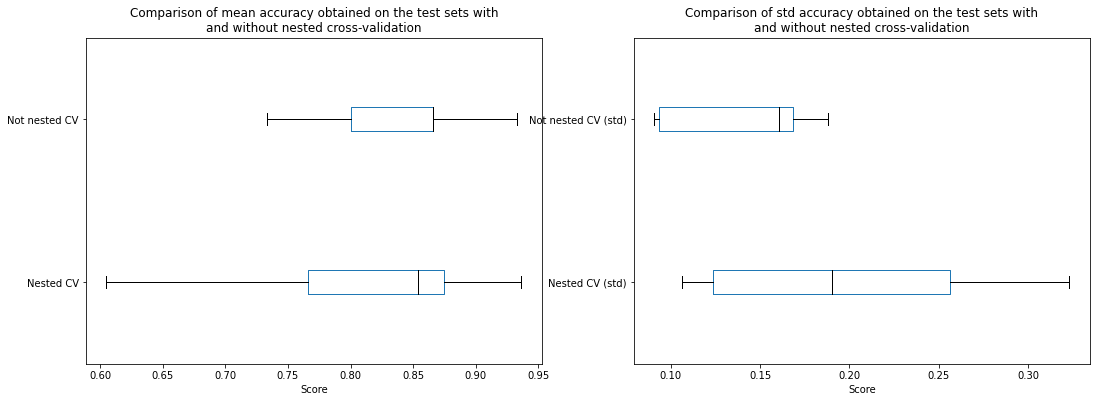

In [26]:
model = LogisticRegressionCV
model_params = {'max_iter': 500, 'Cs': [1e2]}
preprocessing_steps = [ 
     'scaler_spec_ch01',
     'scaler_spec_ch02',
     'scaler_spec_ch03',
     'scaler_freq_pos_ch01', 
     #'scaler_freq_pos_ch02',
     #'scaler_freq_pos_ch03', 
     'scaler_minmax_ch01' ,
     'scaler_minmax_ch02', 
     'scaler_minmax_ch03'
]

_, all_scores_lr, mean_test_score, _, _ = get_score_nested_cv(model, model_params, preprocessing_steps, n_trials=20)
print('Mean score (Nested CV): ',  mean_test_score)

plot_scores_nested_cv(all_scores_lr)

It's noticible the similar are the scores for both for averages Not nested and Nested Cross Validation. However, we should observe that the standard deviation is considerably higher, indicating that there is a variability in results depending on the splitting step. Yet, we see that the range of values of scores is above 0.75, which may be a good sign.

Let's see how would be the results for the test dataset.

Score: 0.9848484848484849


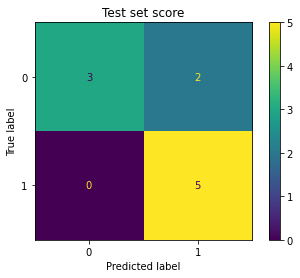

In [27]:
pipeline = get_pipeline(
            model=LogisticRegression(max_iter=500, C=1.0),
            include_preprocessing_steps=preprocessing_steps
)

pipeline.fit(X_train[selected_cols], y_train)
pipeline_score(pipeline, X_test[selected_cols], y_test, "Test set score")

### 2nd model: KNeighbors

Now, let's test another model: KNeighborsClassifier

Starting the nested scoring pipeline
Selected columns: 
	- ch3_skew
	-ch2_mean
	-ch1_freqmax_3
	-ch2_ffund
	-ch1_kurtosis
	-ch1_skew
	-ch2_rms_ratio
	-ch2_X_154
	-ch2_X_166
	-ch1_X_166
	-ch3_rms_ratio
	-ch2_X_167
	-ch3_X_91
	-ch3_X_77
	-ch3_kurtosis
Pipeline preprocessing steps: 
	- scaler_spec_ch01
	-scaler_spec_ch02
	-scaler_spec_ch03
	-scaler_freq_pos_ch01
	-scaler_minmax_ch01
	-scaler_minmax_ch02
	-scaler_minmax_ch03
Mean score (Nested CV):  0.897889796808076


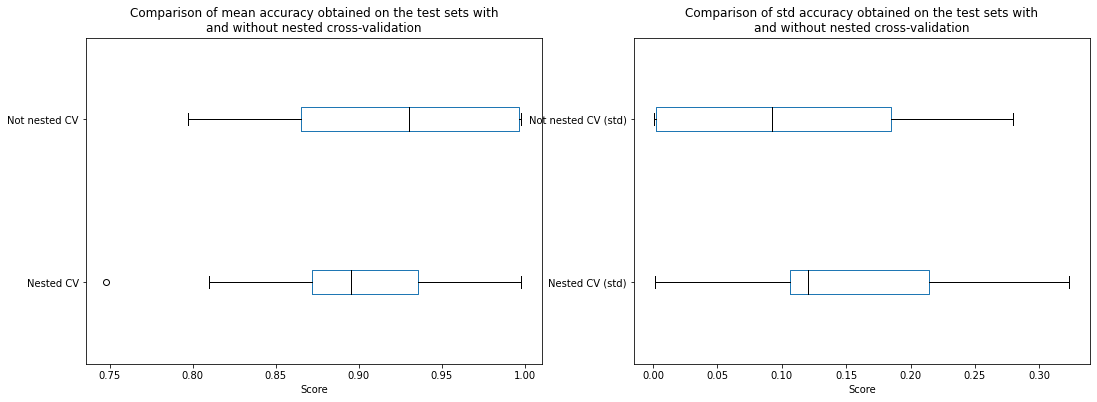

In [28]:
model = KNeighborsClassifier
model_params = {'n_neighbors': 7}

_, all_scores_knn, mean_test_score, _, _ = get_score_nested_cv(model, model_params, preprocessing_steps, n_trials=20)
print('Mean score (Nested CV): ',  mean_test_score)

plot_scores_nested_cv(all_scores_knn)

Score: 0.9848484848484849


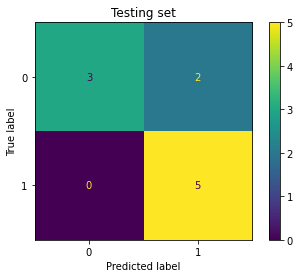

In [29]:
pipeline = get_pipeline(KNeighborsClassifier(n_neighbors=7), include_preprocessing_steps=preprocessing_steps)
pipeline.fit(X_train[selected_cols], y_train)
#pipeline_score(pipeline, X_train[selected_cols], y_train, "Training set")
pipeline_score(pipeline, X_test[selected_cols], y_test, "Testing set")

### 3rd model: SVM

Starting the nested scoring pipeline
Selected columns: 
	- ch3_skew
	-ch2_mean
	-ch1_freqmax_3
	-ch2_ffund
	-ch1_kurtosis
	-ch1_skew
	-ch2_rms_ratio
	-ch2_X_154
	-ch2_X_166
	-ch1_X_166
	-ch3_rms_ratio
	-ch2_X_167
	-ch3_X_91
	-ch3_X_77
	-ch3_kurtosis
Pipeline preprocessing steps: 
	- scaler_spec_ch01
	-scaler_spec_ch02
	-scaler_spec_ch03
	-scaler_freq_pos_ch01
	-scaler_minmax_ch01
	-scaler_minmax_ch02
	-scaler_minmax_ch03
Mean score (Nested CV):  0.973017766200129


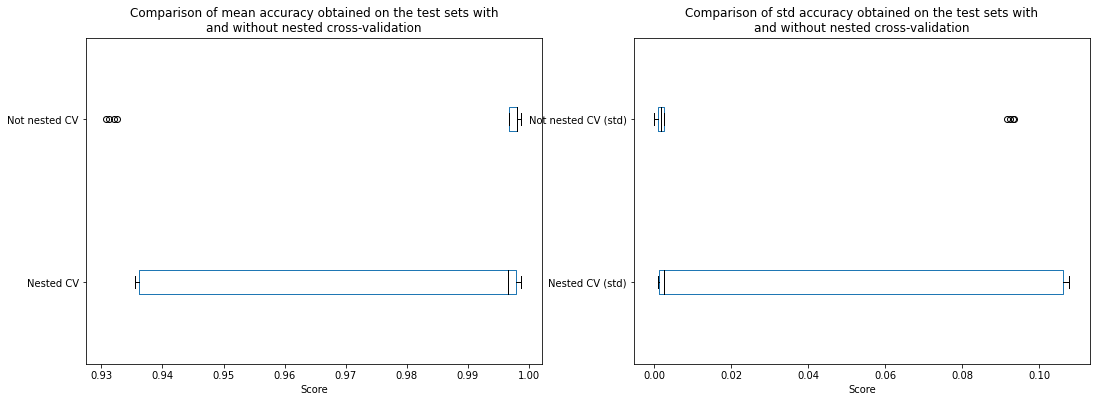

In [30]:
model = SVC
model_params = {'C': 1.0, 'kernel': 'linear'}

_, all_scores_svm, mean_test_score, _, _ = get_score_nested_cv(model, model_params, preprocessing_steps, n_trials=20)
print('Mean score (Nested CV): ',  mean_test_score)

plot_scores_nested_cv(all_scores_svm)

Score: 0.9848484848484849


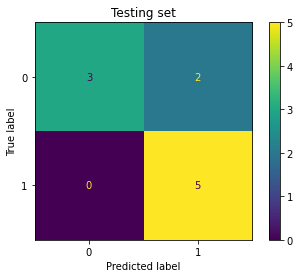

In [31]:
pipeline = get_pipeline(SVC(C=1.0, kernel='linear'), include_preprocessing_steps=preprocessing_steps)
pipeline.fit(X_train[selected_cols], y_train)

#pipeline_score(pipeline, X_train[selected_cols], y_train, "Training set")
pipeline_score(pipeline, X_test[selected_cols], y_test, "Testing set")

## 6. Visualizing the results of the models

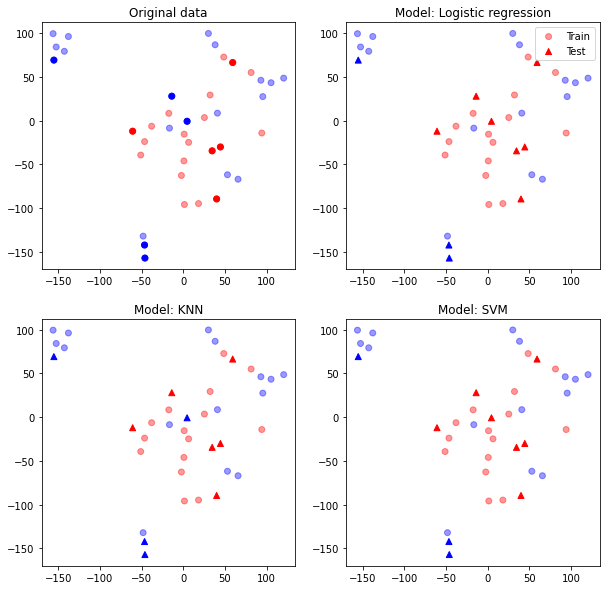

In [32]:
list_models = [
    ('Logistic regression', LogisticRegression(max_iter=500, C=1.0)),
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('SVM', SVC(C=1.0, kernel='linear'))
]

y = X[['label']]

# Getting pipeline only to scaling
pipeline = get_pipeline(LogisticRegression(), include_preprocessing_steps=preprocessing_steps)
X_scaled = pipeline[:-1].fit_transform(X[selected_cols])

X_embedded = TSNE(n_components=2, learning_rate='auto', perplexity=3, init='random').fit_transform(X_scaled)

fig, axs = plt.subplots(int((len(list_models)+1) / 2), 2, figsize=(10, 5 * int((len(list_models) + 1) / 2)) )

def get_color(label_list):
    return ['r' if item==1 else 'b' for item in label_list]

def get_glabels(label_list, train_or_test):
    return ['r' if item==1 else 'b' for item in label_list]

for i, (title, model) in enumerate(list_models):
    
    i = i + 1 # First chart is for original data
    icol = i % 2
    iline = int(i / 2) 
    
    pipeline = get_pipeline(model, include_preprocessing_steps=preprocessing_steps)
    pipeline.fit(X_train[selected_cols], y_train)
    y_pred = pipeline.predict(X_test[selected_cols].sort_index())
    
    # Plotting training samples
    idx_train = X_train.index.tolist()
    idx_train_bool = [i in idx_train for i in range(1, len(X)+1)]
    
    axs[iline, icol].scatter(
                    x=X_embedded[idx_train_bool,0], 
                    y=X_embedded[idx_train_bool,1], 
                    color=get_color(y_train.sort_index()),
                    alpha=0.4,
                    marker='o',
                    label="Train"
                    )
    
    # Plotting testing samples
    idx_test = X_test.index.tolist()
    idx_test_bool = [i in idx_test for i in range(1, len(X)+1)]
    
    axs[iline, icol].scatter(
                    x=X_embedded[idx_test_bool,0], 
                    y=X_embedded[idx_test_bool,1], 
                    color=get_color(y_pred),
                    alpha=1.0,
                    marker='^',
                    label='Test'
                    )
    
    axs[iline, icol].set(title='Model: {}'.format(title))
    
# Original data    
axs[0, 0].scatter(x=X_embedded[:,0], y=X_embedded[:,1], color=get_color(y.label), alpha=0.4)
axs[0, 0].scatter(x=X_embedded[idx_test_bool,0], y=X_embedded[idx_test_bool,1], color=get_color(y_test.sort_index()), alpha=1.0)
axs[0, 0].set(title='Original data')
axs[0,1].legend()

if save_fig:
    figure_name = 'tsne_visualization_results.png'
    fig.savefig(f"{figure_saving_folder}/{figure_name}", format='png')

## 6.1 Comparing the scores

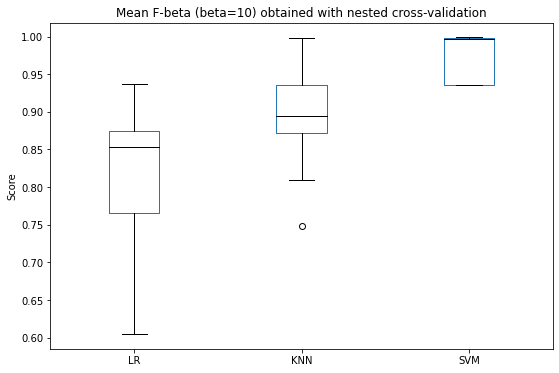

In [33]:
col_plot = 'Nested CV'

list_scores = [
    ('LR', all_scores_lr[col_plot]),
    ('KNN', all_scores_knn[col_plot]),
    ('SVM', all_scores_svm[col_plot])
]

# Renaming the columns
list_scores = [(score[0], score[1].rename(score[0])) for score in list_scores]

# Concatenating the scores series
all_scores = pd.concat([scores[1] for scores in list_scores], axis=1, ignore_index=False)

all_scores

fig, ax = plt.subplots(figsize=(9, 6))
color = {"whiskers": "black", "medians": "black", "caps": "black"}
_ = all_scores.plot.box(color=color, vert=True, ax=ax)
_ = ax.set_ylabel("Score")
_ = ax.set_title("Mean F-beta (beta=10) obtained with nested cross-validation")

if save_fig:
    figure_name = 'comparison_scores.png'
    fig.savefig(f"{figure_saving_folder}/{figure_name}", format='png')

## 6.2 Comparing the confusion matrices

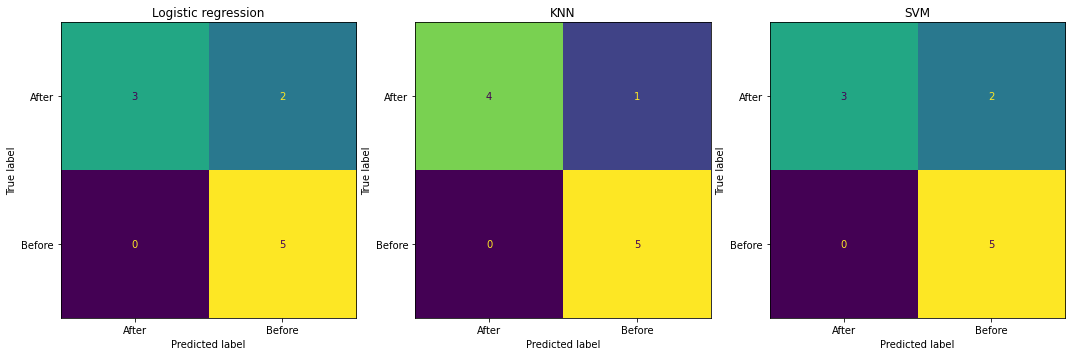

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(18, 7))

for i, (title, model) in enumerate(list_models):
    
    pipeline = get_pipeline(model, include_preprocessing_steps=preprocessing_steps)
    pipeline.fit(X_train[selected_cols], y_train)

    ConfusionMatrixDisplay.from_predictions(y_test, 
                                            pipeline.predict(X_test[selected_cols]), 
                                            normalize=None, 
                                            display_labels=['After', 'Before'],
                                            colorbar=False,
                                            ax=axs[i])

    _ = axs[i].set(title=title)
    
if save_fig:
    figure_name = 'comparison_confusion_matrices.png'
    fig.savefig(f"{figure_saving_folder}/{figure_name}", format='png')